In [18]:
import math
import numpy as np

# Constants
rho0 = 1.225  # Sea level air density (kg/m^3)
h = [0, 3000, 12500, 0]  # Altitudes in meters (takeoff, climb, cruise, landing)
Cd0 = 0.02  # Parasitic drag coefficient 
delta = 0.005  # Induced drag correction factor
AR = 1.8  # Aspect ratio
CL = [1, 0.6, 0.261, 1.7]  # Adjusted Lift coefficients for phases (lower landing CL)
S = 164.9  # Wing area (m^2)
W = 471511.32  # Aircraft weight (N)
gamma = 4  # Climb angle in degrees
v = [72, 130, 290, 55]  # Speeds (m/s) for each phase

# Drag coefficients
Cd = np.array([Cd0 + ((cl ** 2) / (math.pi * AR)) * (1 + delta) for cl in CL])
cd = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, cd in enumerate(cd):
    print(f"{cd} Cd: {Cd[i]:.2f} ")

# Density function
def rho(h):
    rho0 = 1.225
    sea_level_temp = 288.15
    lapse_rate = -0.0065
    R = 287.05
    g = 9.80665
    tropopause_height = 11000

    if isinstance(h, (list, np.ndarray)):
        return np.array([rho(alt) for alt in h])
    if h <= tropopause_height:
        temperature = sea_level_temp + lapse_rate * h
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R))
    else:
        temperature = sea_level_temp + lapse_rate * tropopause_height
        exp_factor = (-g * (h - tropopause_height)) / (R * temperature)
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R)) * math.exp(exp_factor)

# Dynamic pressure calculation
def dynamic_pressure(V, h):
    densities = rho(h)
    return 0.5 * densities * np.array(V)**2

# Thrust required 
def thrust_required(Cd, q, S):
    return Cd * q * S

# Additional thrust for climb
def thrust_required_climb(W, gamma):
    gamma_rad = math.radians(gamma)
    return W * math.sin(gamma_rad)

# thrust calculations for each segment
q = dynamic_pressure(v, h)  # Dynamic pressure for each segment
T = [thrust_required(Cd[i], q[i], S) for i in range(len(v))]
T[1] += thrust_required_climb(W, gamma)  # Add climb-specific thrust

# Segment Results
segments = ["Takeoff", "Climb", "Cruise", "Landing"]
print("Dynamic Pressures for each segment:")
for i, segment in enumerate(segments):
    print(f"{segment}: {q[i]:.2f} Pa")

# Output thrust for each phase
for i, segment in enumerate(segments):
    print(f"{segment} thrust: {T[i]:.2f} N")

# Additional checks for drag and thrust comparison
print("\nClimb vs Landing Drag Comparison:")
print(f"Climb Drag: {T[1]:.2f} N")
print(f"Landing Drag: {T[3]:.2f} N")


Takeoff Cd: 0.20 
Climb Cd: 0.08 
Cruise Cd: 0.03 
Landing Cd: 0.53 
Dynamic Pressures for each segment:
Takeoff: 3175.20 Pa
Climb: 7162.18 Pa
Cruise: 9081.90 Pa
Landing: 1852.81 Pa
Takeoff thrust: 103525.89 N
Climb thrust: 132075.38 N
Cruise thrust: 48083.12 N
Landing thrust: 163036.12 N

Climb vs Landing Drag Comparison:
Climb Drag: 132075.38 N
Landing Drag: 163036.12 N


In [32]:
#thrust specific fuel consumption for each flight phase 
TSFC_static = 0.00014  # kg/N/s (static TSFC) of Rolls Royce ultrafan 
altitude_corrections = [1.0, 0.95, 0.9, 1.0]  # Takeoff, climb, cruise, landing
mach_corrections = [1.0, 0.9, 0.85, 1.0]  # Takeoff, climb, cruise, landing
thrusts = [247819.25, 115180.38, 53957.28, 13119.94]  # Total thrust (N) for each flight segment 
durations = [120, 900, 18000, 60]  # Seconds for each flight segments

# Calculate TSFC and fuel consumption
fuel_burn = []
for i in range(len(thrusts)):
    TSFC = TSFC_static * altitude_corrections[i] * mach_corrections[i]
    fuel_rate = TSFC * thrusts[i]  # kg/s
    fuel_burn_phase = fuel_rate * durations[i]  # kg
    fuel_burn.append(fuel_burn_phase)

# Results
phases = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, phase in enumerate(phases):
    print(f"{phase}:")
    print(f"  TSFC: {TSFC_static * altitude_corrections[i] * mach_corrections[i]:.6f} kg/N/s")
    print(f"  Fuel Burn: {fuel_burn[i]:.2f} kg")








Takeoff:
  TSFC: 0.000140 kg/N/s
  Fuel Burn: 4163.36 kg
Climb:
  TSFC: 0.000120 kg/N/s
  Fuel Burn: 12408.38 kg
Cruise:
  TSFC: 0.000107 kg/N/s
  Fuel Burn: 104018.84 kg
Landing:
  TSFC: 0.000140 kg/N/s
  Fuel Burn: 110.21 kg


Takeoff: 371728.87 N (total for 2 engines)
Climb: 172770.57 N (total for 2 engines)
Cruise: 80935.93 N (total for 2 engines)
Landing: 19679.90 N (total for 2 engines)


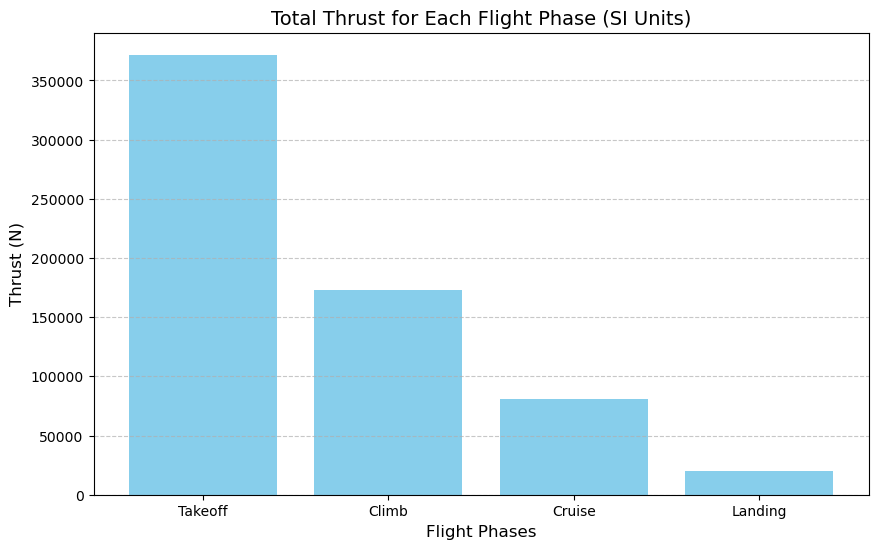

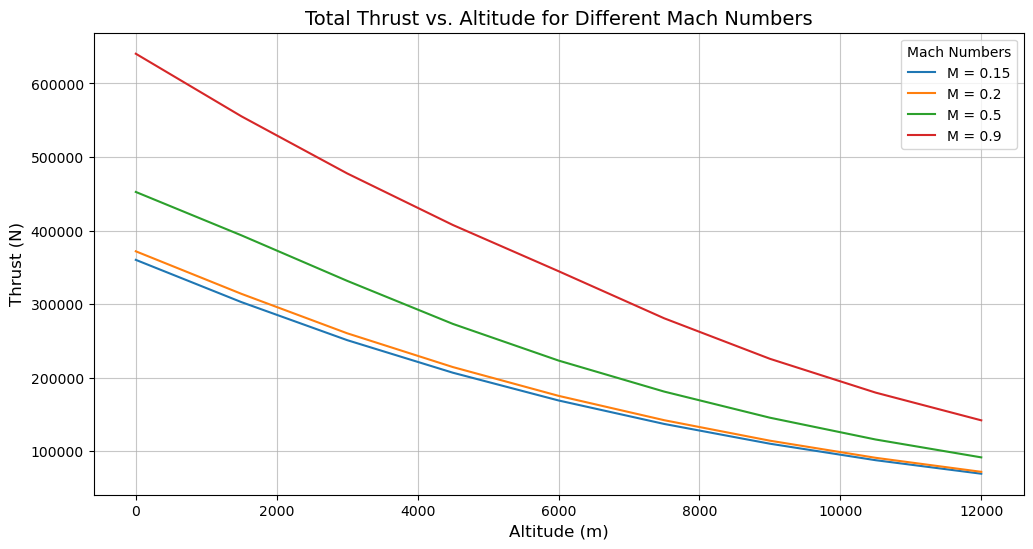

In [11]:
import math
import matplotlib.pyplot as plt

def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C):
    """
    Calculate thrust for a high bypass ratio turbofan engine as a function of altitude and Mach number.
    
    Parameters:
        F0 (float): Engine thrust at sea level and ISA, in N.
        TR (float): Throttle ratio.
        H (float): Altitude in meters.
        M (float): Mach number.
        deltaOAT_C (float): Deviation from ISA temperature in °C.
    
    Returns:
        float: Thrust in N.
    """
    # Constants
    T0 = 288.15  # ISA sea level temperature in Kelvin
    P0 = 101325  # ISA sea level pressure in Pa
    R = 287.05  # Specific gas constant for air in J/(kg·K)
    gamma_air = 1.4  # Ratio of specific heats
    a0 = math.sqrt(gamma_air * R * T0)  # Speed of sound at sea level (m/s)
    
    # Atmospheric properties
    if H <= 11000:  # Troposphere
        T = T0 + (-0.0065 * H) + deltaOAT_C  # Temperature at altitude
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))  # Pressure at altitude
    else:  # Stratosphere (constant temperature)
        T = T0 - 0.0065 * 11000 + deltaOAT_C
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R)) * math.exp(
            -9.80665 * (H - 11000) / (R * T)
        )
    
    rho = P / (R * T)  # Air density in kg/m³
    sigma = rho / 1.225  # Density ratio
    
    # Pressure ratio
    delta = P / P0 * (1 + 0.2 * M ** 2) ** 3.5
    
    # Temperature ratio
    theta = T / T0 * (1 + 0.2 * M ** 2)
    
    # High Bypass Ratio Turbofan Calculation
    if theta <= TR:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M) - 3 * (theta - TR) / (1.5 + M))
    
    return thrust

# Flight phase-specific parameters in SI units
flight_phases = {
    "Takeoff": {"H": 0, "M": 0.2, "TR": 1.0, "deltaOAT_C": 0}, #TR 0.9-1 because full power is required at takeoff
    "Climb": {"H": 5000, "M": 0.3, "TR": 0.8, "deltaOAT_C": -5}, # TR 0.75-0.85 because moderate power is required at climb
    "Cruise": {"H": 12500, "M": 0.9, "TR": 0.6, "deltaOAT_C": -10},#TR 0.5-0.7 because low power is required at cruise 
    "Landing": {"H": 0, "M": 0.15, "TR": 0.4, "deltaOAT_C": 5}, # TR 0.3-0.5 because very low  power is required to decent 
}

# Constants
F0 = 150000 # Sea level thrust per engine in N
num_engines = 2  # Number of engines

# Calculate thrust for each phase
thrust_results = []
phases = []
for phase, params in flight_phases.items():
    H = params["H"]
    M = params["M"]
    TR = params["TR"]
    deltaOAT_C = params["deltaOAT_C"]
    
    thrust = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C)
    total_thrust = thrust * num_engines  # Total thrust for two engines
    thrust_results.append(total_thrust)
    phases.append(phase)
    print(f"{phase}: {total_thrust:.2f} N (total for {num_engines} engines)")

#  Bar plot for thrust in each phase
plt.figure(figsize=(10, 6))
plt.bar(phases, thrust_results, color='skyblue')
plt.title("Total Thrust for Each Flight Phase (SI Units)", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Flight Phases", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#  Thrust vs. Altitude and Mach Number
altitudes = range(0, 12500, 1500)  # Altitudes from 0 to 12,500 m
mach_numbers = [0.15, 0.2, 0.5, 0.9]  #  (Landing, Takeoff, Climb, Cruise)

plt.figure(figsize=(12, 6))
for M in mach_numbers:
    thrusts = [
        high_bypass_turbofan_thrust(F0, 1.0, H, M, 0) * num_engines for H in altitudes
    ]
    plt.plot(altitudes, thrusts, label=f"M = {M}")

plt.title("Total Thrust vs. Altitude for Different Mach Numbers", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Altitude (m)", fontsize=12)
plt.legend(title="Mach Numbers", fontsize=10)
plt.grid(alpha=0.7)
plt.show()



Mission: Passenger
Takeoff Thrust: 165028.96 N
Climb Thrust: 169863.47 N
Cruise Thrust: 75701.05 N
Landing Thrust: 91658.63 N

Mission: Aspen
Takeoff Thrust: 144005.40 N
Climb Thrust: 150668.91 N
Cruise Thrust: 42298.04 N
Landing Thrust: 86727.25 N

Mission: Napa
Takeoff Thrust: 175000.00 N
Climb Thrust: 168795.12 N
Cruise Thrust: 49408.06 N
Landing Thrust: 109163.90 N


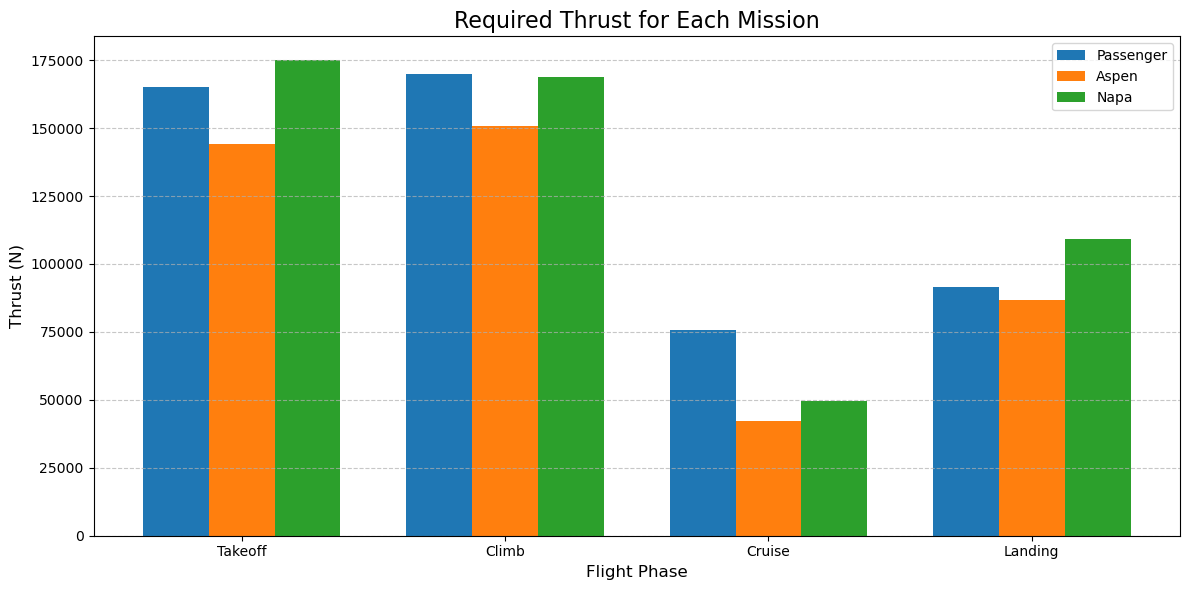

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m³)
g = 9.81  # Gravitational acceleration (m/s²)
conversion_factor = 0.3048  # ft to m conversion

# Inputs 
wing_area = 164.9  # Wing area (m²)
Cl = [1, 0.6, 0.261, 1.5]  # CL for takeoff, climb, cruise, landing
Cd = [0.23, 0.10, 0.03, 0.30]  # CD for takeoff, climb, cruise, landing
gamma_climb = 4  #  climb angle in degrees

# Mission-specific weights (in Newtons)
weights = {
    "Passenger": 471511.32,  # Actual MTOW for Mission 1
    "Aspen": 411444.0,  # MTOW for Mission 2
    "Napa": 500000.0,  # MTOW for Mission 3
}

# Mission-specific altitudes and speeds (m and m/s)
missions = {
    "Passenger": {"altitude": [0, 3000, 12500, 0], "speeds": [72, 140, 290, 55]},
    "Aspen": {"altitude": [0, 2500, 11000, 0], "speeds": [69, 130, 250, 53.5]},
    "Napa": {"altitude": [0, 2000, 10000, 0], "speeds": [75, 130, 250, 60.0227]},
}

# Phases
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Functions
def air_density(h):
    """ISA atmosphere model for air density."""
    if h <= 11000:
        return rho_sl * (1 - 0.0065 * h / 288.15) ** 5.256
    else:
        return 0.36391  # Approximation above 11 km

def dynamic_pressure(rho, V):
    """Calculate dynamic pressure."""
    return 0.5 * rho * V**2

def thrust_required(CD, q, S):
    """Calculate thrust required to overcome drag."""
    return CD * q * S

def climb_thrust(weight, gamma_deg):
    """Calculate thrust required for climb."""
    gamma_rad = math.radians(gamma_deg)
    return weight * math.sin(gamma_rad)

# Store thrust results for visualization
thrust_results = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"\nMission: {mission}")
    W = weights[mission]
    altitudes = data["altitude"]
    speeds = data["speeds"]

    for i, phase in enumerate(phases):
        rho = air_density(altitudes[i])
        q = dynamic_pressure(rho, speeds[i])

        if phase == "Takeoff":
            # Adjust takeoff thrust as 1.2 times the weight
            Thrust_weight_ratio = 0.35  # an assumed thrust to weight ratio because i'm tired LOL 
            T = Thrust_weight_ratio * W
        elif phase == "Climb":
            # Climb thrust includes drag + climb requirement
            T_drag = thrust_required(Cd[i], q, wing_area)
            T = T_drag + climb_thrust(W, gamma_climb)
        else:
            # Thrust for other phases only accounts for drag
            T = thrust_required(Cd[i], q, wing_area)

        thrust_results[mission].append(T)
        print(f"{phase} Thrust: {T:.2f} N")

# Visualization of results 
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot each mission's thrust for all phases
for i, mission in enumerate(missions):
    ax.bar(x + i * width, thrust_results[mission], width, label=mission)

ax.set_title("Required Thrust for Each Mission", fontsize=16)
ax.set_xlabel("Flight Phase", fontsize=12)
ax.set_ylabel("Thrust (N)", fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(phases, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Mission: Passenger
Takeoff:
  Corrected Thrust: 300000.00 N
  Thrust Margin: 186171.59 N
  Fuel Burn: 1912.32 kg
Climb:
  Corrected Thrust: 306923.49 N
  Thrust Margin: 152097.97 N
  Fuel Burn: 19067.96 kg
Cruise:
  Corrected Thrust: 322375.54 N
  Thrust Margin: 266117.33 N
  Fuel Burn: 131930.63 kg
Landing:
  Corrected Thrust: 300000.00 N
  Thrust Margin: 118197.75 N
  Fuel Burn: 1527.14 kg
Mission: Aspen
Takeoff:
  Corrected Thrust: 300000.00 N
  Thrust Margin: 201852.04 N
  Fuel Burn: 1648.89 kg
Climb:
  Corrected Thrust: 307469.32 N
  Thrust Margin: 138652.41 N
  Fuel Burn: 20754.20 kg
Cruise:
  Corrected Thrust: 345572.66 N
  Thrust Margin: 309771.60 N
  Fuel Burn: 78321.02 kg
Landing:
  Corrected Thrust: 322375.54 N
  Thrust Margin: 169611.15 N
  Fuel Burn: 1194.15 kg
Mission: Napa
Takeoff:
  Corrected Thrust: 289937.95 N
  Thrust Margin: 159267.58 N
  Fuel Burn: 2271.45 kg
Climb:
  Corrected Thrust: 294883.17 N
  Thrust Margin: 64327.22 N
  Fuel Burn: 29554.13 kg
Cruise:
  Corre

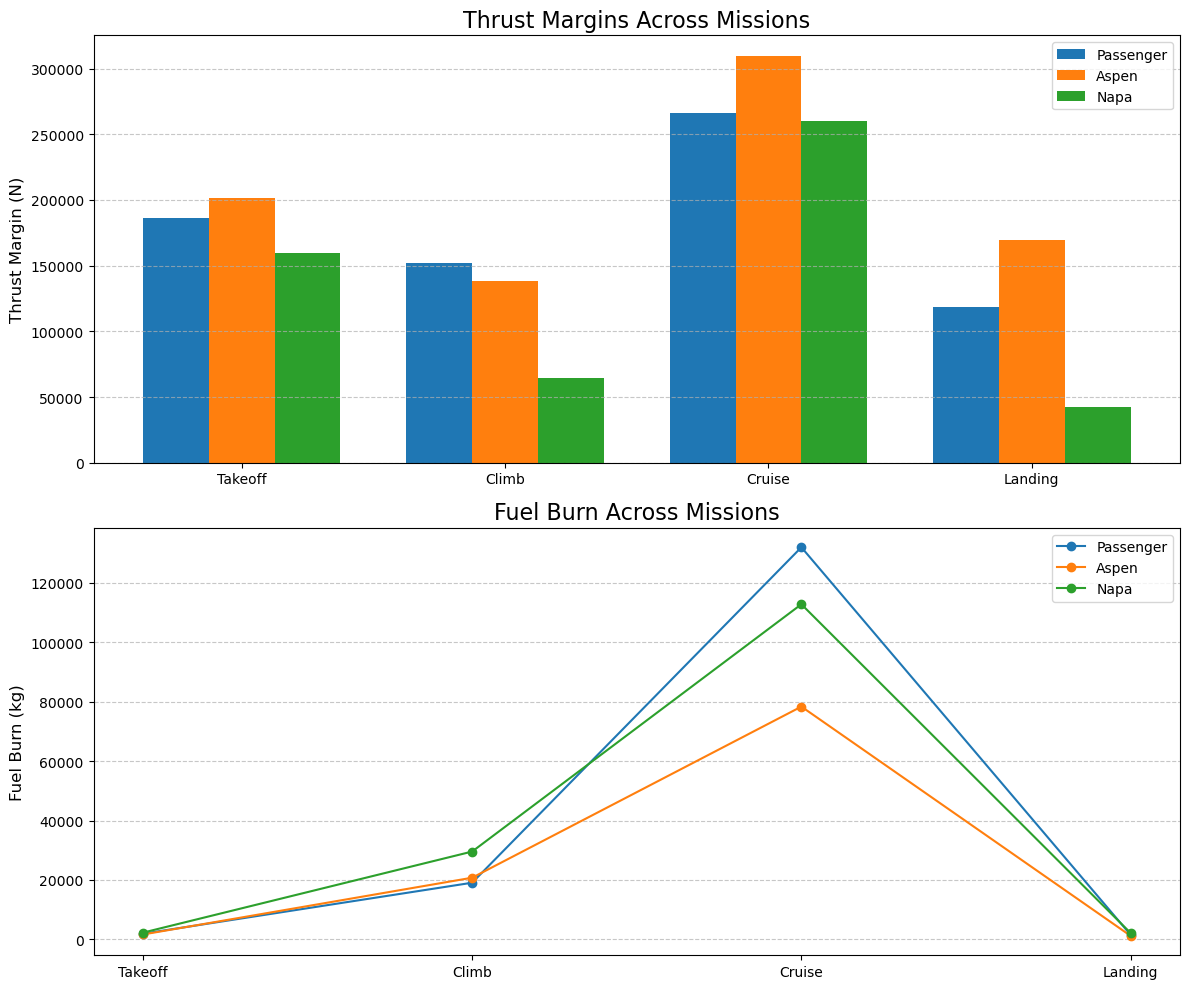

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Constants .... pay attention to the engine static thrust 
T_static_per_engine = 150000  # Static thrust per engine (N)
engines = 2  # Number of engines
T_static_total = T_static_per_engine * engines  # Total available thrust (N)
T0 = 288.15  # Standard temperature (K)
rho_sl = 1.225  # Sea level air density (kg/m³)
TSFC_static = 0.00014  # Static TSFC (kg/N/s)
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Mission-specific inputs
missions = {
    "Passenger": {
        "altitude": [0, 5000, 12500, 0],
        "speeds": [70, 140, 290, 60],
        "temperatures": [288.15, 281.65, 268.15, 288.15],
        "thrust_required": [113828.41, 154825.52, 56258.21, 181802.25],
        "durations": [120, 900, 18000, 60]
    },
    "Aspen": {
        "altitude": [0, 2500, 11000, 0],
        "speeds": [65, 130, 230, 55],
        "temperatures": [288.15, 281.15, 250.15, 268.15],
        "thrust_required": [98147.96, 168816.91, 35801.06, 152764.39],
        "durations": [120, 900, 18000, 60]
    },
    "Napa": {
        "altitude": [0, 2000, 12500, 0],
        "speeds": [75, 150, 240, 70],
        "temperatures": [298.15, 293.15, 283.15, 298.15],
        "thrust_required": [130670.37, 230555.95, 45534.47, 247453.06],
        "durations": [120, 900, 18000, 60]
    },
}

# Saved results 
thrust_margins = {mission: [] for mission in missions}
fuel_burns = {mission: [] for mission in missions}

#  calculations
for mission, data in missions.items():
    print(f"Mission: {mission}")
    thrust_required = data["thrust_required"]
    temperatures = data["temperatures"]
    durations = data["durations"]

    for i, phase in enumerate(phases):
        # Correct available thrust for temperature
        T_corrected = T_static_total * T0 / temperatures[i]
        
        # thrust margin
        margin = T_corrected - thrust_required[i]
        thrust_margins[mission].append(margin)
        
        #  fuel burn
        TSFC_corrected = TSFC_static * (temperatures[i] / T0)  # Adjust TSFC
        fuel_burn = TSFC_corrected * thrust_required[i] * durations[i]
        fuel_burns[mission].append(fuel_burn)

        print(f"{phase}:")
        print(f"  Corrected Thrust: {T_corrected:.2f} N")
        print(f"  Thrust Margin: {margin:.2f} N")
        print(f"  Fuel Burn: {fuel_burn:.2f} kg")


fig, axs = plt.subplots(2, 1, figsize=(12, 10))


x = np.arange(len(phases))
width = 0.25
for i, mission in enumerate(missions):
    axs[0].bar(x + i * width, thrust_margins[mission], width, label=mission)
axs[0].set_title("Thrust Margins Across Missions", fontsize=16)
axs[0].set_ylabel("Thrust Margin (N)", fontsize=12)
axs[0].set_xticks(x + width)
axs[0].set_xticklabels(phases)
axs[0].legend(fontsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)


for mission in missions:
    axs[1].plot(phases, fuel_burns[mission], marker='o', label=mission)
axs[1].set_title("Fuel Burn Across Missions", fontsize=16)
axs[1].set_ylabel("Fuel Burn (kg)", fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

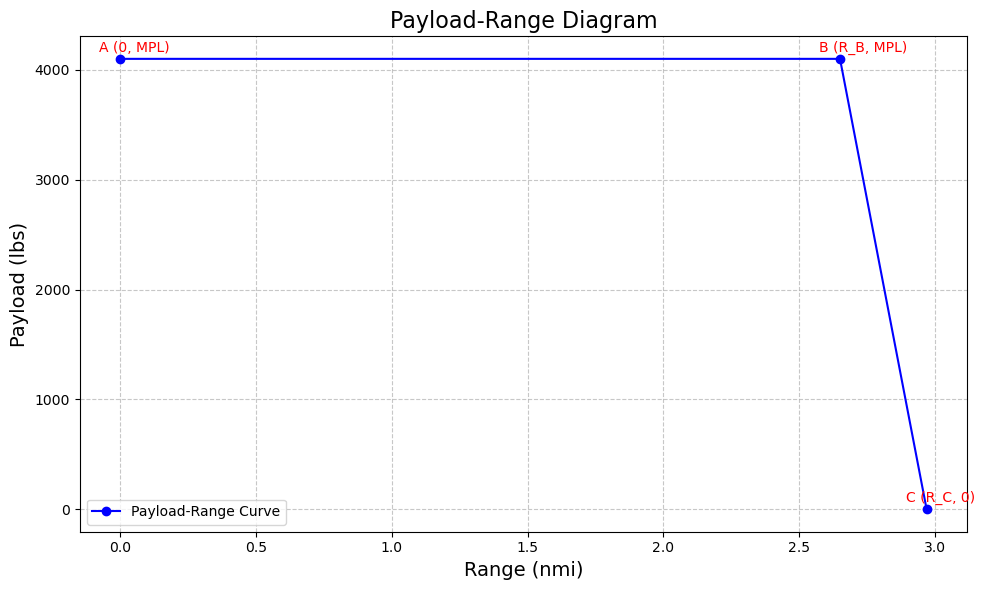

(2.650338267853146, 2.969195778529199)

In [ ]:
#payload range 

# Constants for the design
MTOW = 106000  # Maximum Takeoff Weight (lbs)
OEW = 52886.46    # Operating Empty Weight (lbs)
MFW = 49013.54    # Maximum Fuel Weight (lbs)
MZFW = MTOW- MFW  # Maximum zero fuel weight 
MPL = MZFW - OEW     # Maximum Payload (lbs)
c = 0.45       # TSFC (lb/lb/hr)
LbyD = 11.62   # Lift-to-Drag Ratio
V = 595.35     # Cruise speed in knots
V_ftps = V * 1.68781  # Convert knots to ft/s

# Cruise Fuel Weight Fraction (updated)
WF_frac_cruise = 1.683

# Helper Function: Breguet Range Equation
def breguet_range(W1, W2, LbyD, c, V_ftps):
    return (LbyD / c) * np.log(W1 / W2) * (V_ftps / 6076)  # Range in nautical miles

# Calculate points A, B, and C for the payload-range diagram

# Point A: Max Payload, zero range (fuel burned is zero)
R_A = 0  # Range is zero
Payload_A = MPL

# Point B: Max Payload, max range with fuel
W1_B = OEW + MPL + MFW  # Initial weight
W2_B = OEW + MPL        # Final weight after burning fuel
R_B = breguet_range(W1_B, W2_B, LbyD, c, V_ftps)  # Range
Payload_B = MPL

# Point C: Zero Payload, max range
W1_C = MTOW  # Initial weight is MTOW
W2_C = OEW   # Final weight is just OEW
R_C = breguet_range(W1_C, W2_C, LbyD, c, V_ftps)  # Range
Payload_C = 0

# Plot the Payload-Range Diagram
ranges = [R_A, R_B, R_C]
payloads = [Payload_A, Payload_B, Payload_C]

plt.figure(figsize=(10, 6))
plt.plot(ranges, payloads, marker='o', linestyle='-', color='blue', label='Payload-Range Curve')
plt.title("Payload-Range Diagram", fontsize=16)
plt.xlabel("Range (nmi)", fontsize=14)
plt.ylabel("Payload (lbs)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate Points
plt.annotate("A (0, MPL)", (R_A, Payload_A), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
plt.annotate("B (R_B, MPL)", (R_B, Payload_B), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
plt.annotate("C (R_C, 0)", (R_C, Payload_C), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

# Return key range values for inspection
R_B, R_C


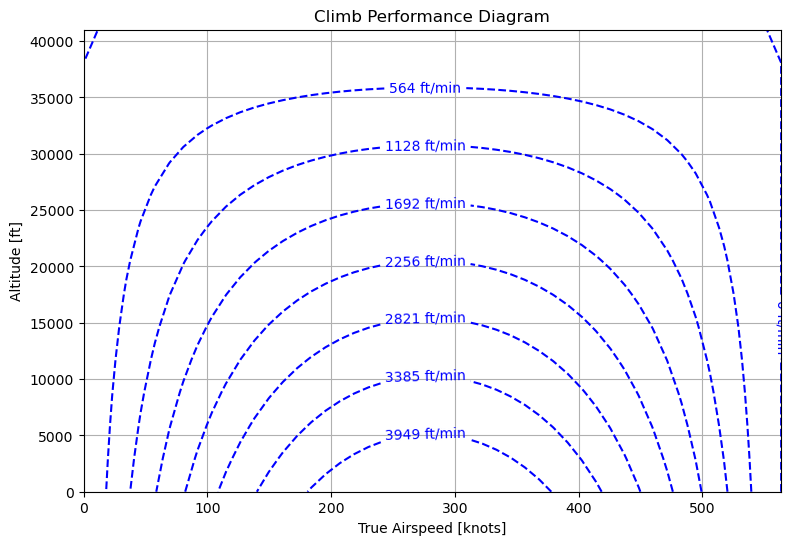

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Constants 
altitudes = np.linspace(0, 12500, 15)  # Altitudes in meters
airspeeds = np.linspace(0, 290, 50)  # True airspeed in m/s
weight = 106000 * 0.453592  # Maximum Takeoff Weight in kg
g = 9.81  # Gravity in m/s^2

# Conversion factors
meters_to_feet = 3.28084
meters_per_second_to_knots = 1.94384
meters_per_second_to_ft_per_min = 196.85039

# Converted arrays
altitudes_ft = altitudes * meters_to_feet  # Convert altitude to feet
airspeeds_knots = airspeeds * meters_per_second_to_knots  # Convert airspeeds to knots

# Functions for Thrust, Drag, and Power
def thrust(altitude, airspeed):
    return 150000 * (1 - altitude / 12500) * (1 - airspeed / 290)

def drag(altitude, airspeed):
    return 0.02 * airspeed**2 * (1 - altitude / 12500)

def power_available(altitude, airspeed):
    return thrust(altitude, airspeed) * airspeed

# Compute climb rates (m/s)
climb_rate = np.zeros((len(altitudes), len(airspeeds)))
for i, alt in enumerate(altitudes):
    for j, spd in enumerate(airspeeds):
        power_avail = power_available(alt, spd)
        power_req = drag(alt, spd) * spd
        excess_power = power_avail - power_req
        climb_rate[i, j] = excess_power / (weight * g) if excess_power > 0 else 0

# Convert climb rates to ft/min
climb_rate_ft_min = climb_rate * meters_per_second_to_ft_per_min

# Define contour levels dynamically based on data range
max_climb_rate = np.max(climb_rate_ft_min)
contour_levels = np.linspace(0, max_climb_rate, 9)  # Dynamically include max climb rate

# Plot the Climb Performance Diagram
plt.figure(figsize=(9, 6))
CS = plt.contour(airspeeds_knots, altitudes_ft, climb_rate_ft_min, levels=contour_levels, colors='blue', linestyles='dashed')
plt.clabel(CS, inline=1, fontsize=10, fmt="%1.0f ft/min")

# Finalize plot
plt.xlabel('True Airspeed [knots]')
plt.ylabel('Altitude [ft]')
plt.title('Climb Performance Diagram')
plt.grid(True)

# Ensure the axis covers all relevant data
plt.xlim(airspeeds_knots[0], airspeeds_knots[-1])
plt.ylim(altitudes_ft[0], altitudes_ft[-1])

plt.show()


In [6]:
# Takeoff distance calculation for aircraft design

# Known constants
W0 = 471672.55  # Maximum takeoff weight (N)
V_stall = 60 #58.188   Stall speed (m/s)
V_LOF = 1.1 * V_stall  # Liftoff speed (m/s)
V_2 = 1.2 * V_stall  # Climb-out speed (m/s)
print (V_2)
T = 150000  # Takeoff thrust (N)
mu = 0.02  # Friction coefficient
rho = 1.225  # Sea level air density (kg/m^3)
S = 164.9  # Wing area (m^2)
C_D = 0.20  # Drag coefficient
C_L = 1.0  # Lift coefficient
C_D0 = 0.02  # Zero-lift drag coefficient
C_Lmax = 1.099  # Maximum lift coefficient
g = 9.81  # Gravitational acceleration (m/s^2)
Lambda = 0.161  # Taper ratio
h = 10.668  # Height at which takeoff is completed (m)
A = 1.5  # Aspect ratio

T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)
mu_prime = mu + (0.72 * (C_D0 / C_Lmax))  # Effective friction coefficient

# Ground run distance (x_g in meters)
x_g = ((V_LOF**2) / (2 * g)) / ((T_bar / W0) - mu_prime)

# Climb angle (gamma_LOF in radians)
gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

# Air run distance (x_a in meters)
x_a = ((V_LOF**2) / (2 * g)) + (h / gamma_lof)

# Total takeoff distance (meters)
Takeoff_distance = x_g + x_a

# Print results
print("Takeoff Distance Calculations:")
print(f"Stall Speed (V_stall): {V_stall:.2f} m/s")
print(f"Liftoff Speed (V_LOF): {V_LOF:.2f} m/s")
print(f"Climb-out Speed (V_2): {V_2:.2f} m/s")
print(f"Average Thrust (T_bar): {T_bar:.2f} N")
print(f"Effective Friction Coefficient (mu_prime): {mu_prime:.4f}")
print(f"Ground Run Distance (x_g): {x_g:.2f} m")
print(f"Air Run Distance (x_a): {x_a:.2f} m")
print(f"Total Takeoff Distance: {Takeoff_distance:.2f} m")


72.0
Takeoff Distance Calculations:
Stall Speed (V_stall): 60.00 m/s
Liftoff Speed (V_LOF): 66.00 m/s
Climb-out Speed (V_2): 72.00 m/s
Average Thrust (T_bar): 139536.77 N
Effective Friction Coefficient (mu_prime): 0.0331
Ground Run Distance (x_g): 845.04 m
Air Run Distance (x_a): 722.83 m
Total Takeoff Distance: 1567.87 m


In [5]:
import math
# Landing Distance Calculation 
W_landing = 253488.33 # lalnding weight in Newton 
S = 164.5 # wing area in m
rho = 1.225 # density at sea level in kg/m^3
C_Lmax = 1.099 # maximum wing lift coefficient 
h_ob = 15  # Height of hypothetical object (m)
h_r = 1.5  # Rotation height (m)
gamma_deg = 3  # Descent angle (degrees)
V_stall = ((2*W_landing)/(S*rho*C_Lmax))**0.5
print (V_stall)
V2 = 1.3 *V_stall # Approach speed (m/s)
n = 1.2  # Load factor
V_TD = 1.15*V_stall # Touchdown speed (m/s)
print (V_TD)
a_mean = 2  # Mean deceleration (m/s^2)

def calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean):
    # Convert angles from degrees to radians
    gamma = math.radians(gamma_deg)

    # Approach distance and time
    x3 = (h_ob - h_r) / math.tan(gamma)
    t3 = x3 / (V2 * math.cos(gamma))

    # Rotation radius, distance, and time
    R = (V2 ** 2) / (9.81 * (n - 1))  # g = 9.81 m/s^2
    x2 = R * math.sin(gamma)
    t2 = (gamma * V2) / (9.81 * (n - 1))

    # Ground run distance
    x_g = (V_TD ** 2) / (2 * a_mean)

    # Total landing distance
    total_distance = x3 + x2 + x_g

    return {
        "Approach Distance (x3)": x3,
        "Approach Time (t3)": t3,
        "Rotation Distance (x2)": x2,
        "Rotation Time (t2)": t2,
        "Ground Run Distance (xg)": x_g,
        "Total Landing Distance": total_distance
    }

    # Convert values to feet and seconds 
def display_results(result):
    conversion_factors = {
        "m_to_ft": 3.28084,
        "m_to_ft_min": 3.28084 / 60,
    }
    
    print("Landing Distance Calculation Results:")
    for key, value in result.items():
        if "Distance" in key or "x" in key:  # For distances
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")
        elif "Time" in key:  # For times
            print(f"{key}: {value:.2f} s")
        else:  # For total values
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")

# Calculate and display landing distance with units
result = calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean)
display_results(result)



47.845835331344226
55.022710631045854
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 4.15 s
Rotation Distance (x2): 103.20 m (338.58 ft)
Rotation Time (t2): 1.66 s
Ground Run Distance (xg): 756.87 m (2483.18 ft)
Total Landing Distance: 1117.67 m (3666.89 ft)


In [ ]:
import math
#theres a mistake 
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)
   

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = T0 - L * altitude_m
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return density

def takeoff_distance(weight, wing_area, cl_max, thrust_to_weight, altitude_ft, temperature_c, rolling_resistance=0.03):
    """
    Estimate takeoff distance based on input parameters.
    """
    rho = air_density(altitude_ft, temperature_c)  # Air density
    g = 9.81  # Gravity (m/s^2)

    # Simplified takeoff distance equation
    takeoff_dist = (weight**2) / (
        2 * rho * g * wing_area * cl_max * (thrust_to_weight - rolling_resistance)
    )
    return takeoff_dist

def landing_distance(weight, wing_area, cl_max, braking_coefficient, altitude_ft, temperature_c, wind_speed=0):
    """
    Estimate landing distance based on input parameters.
    """
    rho = air_density(altitude_ft, temperature_c)  # Air density
    g = 9.81  # Gravity (m/s^2)

    # Approach speed estimation
    v_approach = math.sqrt(2 * weight / (rho * wing_area * cl_max))

    # Adjust approach speed for headwind or tailwind
    v_ground = v_approach - wind_speed

    # Landing distance estimation
    landing_dist = (v_ground**2) / (2 * g * braking_coefficient)
    return max(landing_dist, 0)  # Ensure non-negative distance

def great_circle_distance(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points on the Earth.
    """
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c  # Distance in km
    return distance * 0.539957  # Convert to nautical miles

# Missions Calculations 
missions = {
    "Passenger Mission": {
        "departure_altitude": 800,
        "arrival_altitude": 1026,
        "temperature": 15,  #  normal Standard day temperature 
        "cl_max": 1.099,
        "thrust_to_weight": 0.4,
        "wing_area": 164.9,  # in m^2
        "weight": 471672.55,  #  in N
        "braking_coefficient": 0.3,
        "rolling_resistance": 0.02,
        "wind_speed": 0,  # No wind assumed
       
    },
    "Aspen Economic Mission": {
        "departure_altitude": 800,
        "arrival_altitude": 7820,
        "temperature": -7,  # Winter temperature at Aspen (20°F)
        "cl_max": 1.099,
        "thrust_to_weight": 0.35,
        "wing_area": 164.9,  #  in m^2
        "weight": 411444.0,  # MTOW for Mission 2
        "braking_coefficient": 0.16,
        "rolling_resistance": 0.02,
        "wind_speed": 5,  # assumed  headwind at landing
    },
    "Napa Economic Mission": {
        "departure_altitude": 35,
        "arrival_altitude": 7316,
        "temperature": 24,  # Summer temperature
        "cl_max": 1.099,
        "thrust_to_weight": 0.38,
        "wing_area": 164.9,  #  in m^2
        "weight": 500000.0,  #  in N
        "braking_coefficient": 0.16,
        "rolling_resistance": 0.02,
        "wind_speed": -3,  # assumed  tailwind at landing
    },
}
# Calculations for each mission
for mission, params in missions.items():
    takeoff_dist = takeoff_distance(
        params["weight"],
        params["wing_area"],
        params["cl_max"],
        params["thrust_to_weight"],
        params["departure_altitude"],
        params["temperature"],
        params["rolling_resistance"],
    )

    landing_dist = landing_distance(
        params["weight"],
        params["wing_area"],
        params["cl_max"],
        params["braking_coefficient"],
        params["arrival_altitude"], 
        params["temperature"],
        params["wind_speed"],
    )

    print(f"{mission}:")
    print(f"  Takeoff Distance: {takeoff_dist:.2f} meters")
    print(f"  Landing Distance: {landing_dist:.2f} meters\n")


Passenger Mission:
  Takeoff Distance: 138366186.00 meters
  Landing Distance: 749.29 meters

Aspen Economic Mission:
  Takeoff Distance: 111981875.20 meters
  Landing Distance: 1250.66 meters

Napa Economic Mission:
  Takeoff Distance: 164621365.25 meters
  Landing Distance: 2092.89 meters



: 